## Извлекаем дыры из сабсетов


*   все результаты работы ripserer'а (h0_\*.npy, h1_\*.npy, ru_word_holes_\*.npy) в папке holes
*   в результате получаем результаты фильтрации: индексы дыр внутри сабсета, соответсвующие условиям фильтрации (by diameter/lifetime/syn)
*   чтобы вывести слова на контуре - загружаем файлы ru_word_partition и словарь эмбеддингов



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from tqdm.auto import tqdm, trange

## Извлекаем дыры

In [11]:
def get_cycles(cycles):
    """
        спиок ребер -> циклы
    """
    new_cycle_flag = True
    cycles_list = []
    cur_cycle = set()
    for a, b in cycles:
        if new_cycle_flag:
            cur_cycle.update([a])
            cur_cycle.update([b])
            cycles_list.append([])
            new_cycle_flag = False
            continue
        if a in cur_cycle:
            cur_cycle.remove(a)
            cycles_list[-1].append(a)
        else:
            cur_cycle.update([a])
        if b in cur_cycle:
            cur_cycle.remove(b)
            cycles_list[-1].append(b)
        else:
            cur_cycle.update([b])
        if len(cur_cycle) == 0:
            new_cycle_flag = True
    return cycles_list

In [10]:
import glob
def get_holes_per_chunk(dir="holes/", filenames="ru_word_holes_norm_km5_*.npy"):
    '''
      извлекаем из отдельного чанка
    '''
    hole_contours = {}
    for file in glob.glob(f"{dir}/{filenames}"):
        hole_contours["_".join(file.split('_')[5:])[:-4]] = get_cycles(np.load(file) - 1) # !attention to filenames!
    return hole_contours

In [9]:
import glob
def collect_holes_from_chunks(dir="holes/"):
    '''
      извлекаем из вссех чанков
    '''
    def get_homology_birth_death(files):
        h_bd = {}
        for fn in files:
            chunk_num = "_".join(fn.split('_')[3:])[:-4] # !attention to filenames!
            h_bd[chunk_num] = np.load(fn)
        h_all = np.hstack(list(h_bd.values()))
        h_lifetimes = np.diff(h_all, axis=0)
        return h_all, h_lifetimes, h_bd

    h0_all, h0_lifetimes, h0_bd = get_homology_birth_death(glob.glob(f"{dir}/h0_norm_km5_*.npy"))
    h1_all, h1_lifetimes, h1_bd = get_homology_birth_death(glob.glob(f"{dir}/h1_norm_km5_*.npy"))
    plt.scatter(*h0_all, s=.5, label='$H_0$');
    plt.scatter(*h1_all, s=.5, label='$H_1$');
    plt.legend();
    plt.xlabel('birth')
    plt.ylabel('death')
    plt.show()
    return (h0_all, h0_lifetimes, h0_bd), (h1_all, h1_lifetimes, h1_bd)

## Вычисляем диаметры

In [2]:
from scipy.spatial.distance import pdist, squareform

def get_hole_diam(filtered_by_lifetime, h1_contours, lang='ru', part='word'):
    '''
      диаметры дыр для чанков, в которых есть дыры, прошедшие фильтрацию по lifetime
    '''
    hole_diam = {}
    for n_chunk in tqdm(filtered_by_lifetime):
        if filtered_by_lifetime[n_chunk] == -1: continue
        hole_diam[n_chunk] = []

        chunk_emb = np.load(f'holes/{lang}_{part}_norm_5_{n_chunk}.npy') # !attention to filenames!

        chunk_pdist = squareform(pdist(chunk_emb, metric='cosine'))
        cycles_list = h1_contours[n_chunk][filtered_by_lifetime[n_chunk]:] # list of cycles of holes, filtered by lifetime (in one chunk)
        for edges in cycles_list:
            hole_diam[n_chunk].append(chunk_pdist[edges][:,edges].max())
    return hole_diam

## Фильтры

In [ ]:
# save first indices beginning from which holes are more persistent
def filter_by_lifetimes(h1_lifetimes, h1_bd, h1_contours, q=.99):
    q = np.quantile(h1_lifetimes, q=.99)
    filtered_by_lifetime = {}
    for n_chunk in h1_bd:
        if n_chunk not in h1_contours: continue
        chunk_n_holes = len(h1_contours[n_chunk])
        idx = np.where(np.diff(h1_bd[n_chunk], axis=0)[0][-chunk_n_holes:] > q)[0]
        filtered_by_lifetime[n_chunk] = idx[0] if len(idx) else -1
    return filtered_by_lifetime

In [ ]:
def filter_by_syn(hole_diam, filtered_by_lifetime, threshold=1.3):
    filtered_by_syn = {}
    for n_chunk in hole_diam:
        a = np.where(np.array(hole_diam[n_chunk]) > threshold)[0]
        if len(a):
            filtered_by_syn[n_chunk] = a + filtered_by_lifetime[n_chunk] # index of hole in cycles list
    return filtered_by_syn

In [ ]:
def filter_by_hole_diam(hole_diam, filtered_by_lifetime, q=.99):
    q_ = np.quantile(np.hstack(list(hole_diam.values())), q=q)
    filtered_by_hole_diam = {}
    for n_chunk in hole_diam:
        idx = np.where(hole_diam[n_chunk] > q_)[0]
        if len(idx):
            filtered_by_hole_diam[n_chunk] = idx + filtered_by_lifetime[n_chunk]
    return filtered_by_hole_diam

## Обработка данных

In [ ]:
# контуры из всех кластеров
h1_contours = get_holes_per_chunk("holes/", "ru_word_holes_norm_km5_*.npy")

In [ ]:
# в ripserer были отобраны 500 самых персистентных циклов
print([(cn, len(h1_contours[cn]))for cn in h1_contours])

[('2', 500), ('0', 500), ('1', 500), ('4', 500), ('3', 500)]


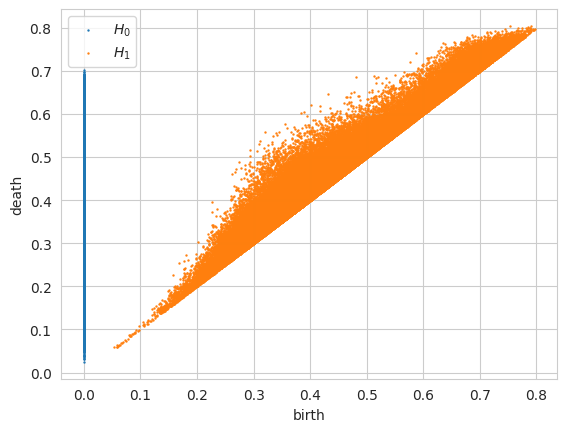

In [ ]:
# собираем все вместе
(h0_all, h0_lifetimes, h0_bd), (h1_all, h1_lifetimes, h1_bd) = collect_holes_from_chunks("holes/")

In [ ]:
h1_all.shape # все дыры

(2, 151752)

In [ ]:
h0_all.shape # все точки (слова)

(2, 72111)

### by lifetime

In [ ]:
filtered_by_lifetime = filter_by_lifetimes(h1_lifetimes, h1_bd, h1_contours)

filtered_by_lifetime

{'4': -1,
 '2': np.int64(389),
 '1': np.int64(418),
 '0': np.int64(0),
 '3': np.int64(460)}

In [ ]:
np.save("holes/filtered_by_lifetimes_norm_km5.npy", filtered_by_lifetime)

In [17]:
filtered_by_lifetime = np.load("holes/filtered_by_lifetimes_norm_km5.npy", allow_pickle=True).item()

### hole diams

In [ ]:
hole_diam = get_hole_diam(filtered_by_lifetime, h1_contours, lang='ru', part='word')

  0%|          | 0/5 [00:00<?, ?it/s]

In [20]:
np.save("holes/hole_diams_norm_km5.npy", hole_diam)

### by synonyms

In [ ]:
hole_diam = np.load("holes/hole_diams.npy", allow_pickle=True).item()

In [ ]:
filtered_by_syn = filter_by_syn(hole_diam, filtered_by_lifetime, 1.3)

In [ ]:
filtered_by_syn

{'0': array([403, 437])}

In [ ]:
np.save("holes/filtered_by_lifetimes_and_syn_norm_km5.npy", filtered_by_syn)

### by hole diam

In [ ]:
# для данных, полученных из 10 кластеров
# filtered_by_hole_diam = filter_by_hole_diam(hole_diam, filtered_by_lifetime, q=.995)
# filtered_by_hole_diam

{'3': array([281, 389, 403, 443, 463, 499])}

In [ ]:
filtered_by_hole_diam_km5 = filter_by_hole_diam(hole_diam, filtered_by_lifetime, q=.99)
filtered_by_hole_diam_km5

{'0': array([237, 375, 403, 426, 437, 470, 477, 486])}

In [ ]:
filtered_by_hole_diam_km5 = filter_by_hole_diam(hole_diam, filtered_by_lifetime, q=.995)
filtered_by_hole_diam_km5

{'0': array([403, 437, 477, 486])}

In [ ]:
np.save("holes/filtered_by_lifetimes_and_hole_diam_norm_km5_995.npy", filtered_by_hole_diam_km5)

## Слова на границе

In [ ]:
# для km=10
# word_dictionary = np.load("ru_cbow_normalized_dict.npy", allow_pickle=True).item()
# words = list(word_dictionary.keys())
# word_partition = np.load('ru_word_partition_norm.npy')

In [ ]:
word_dictionary = np.load("ru_cbow_normalized_dict.npy", allow_pickle=True).item()
words = list(word_dictionary.keys())
word_partition = np.load('ru_word_partition_norm_5.npy')

In [ ]:
def words_on_contour(filtered_holes, words=words, word_partition=word_partition):
  for c in filtered_holes:
    cluster_idx = np.where(word_partition == c)[0]
    print(f"\nCluster {c}:")
    print('*' * 20)

    if len(cluster_idx) == 0:
        print(f"No words found in cluster {c}")
        continue

    for hole_num in filtered_holes[c]:
        try:
            contour_indices = h1_contours[c][hole_num]

            if isinstance(contour_indices, (list, np.ndarray)):
                words_in_hole = []
                for idx in contour_indices:
                    if 0 <= idx < len(cluster_idx):
                        word = words[cluster_idx[idx]]
                        words_in_hole.append(word.tolist() if hasattr(word, 'tolist') else word)
                    else:
                        print(f"Index {idx} out of bounds for cluster {c}")
                print(f"Hole {hole_num}: {words_in_hole}")
            else:
                if 0 <= contour_indices < len(cluster_idx):
                    word = words[cluster_idx[contour_indices]]
                    print(f"Hole {hole_num}: {word.tolist() if hasattr(word, 'tolist') else word}")
                else:
                    print(f"Index {contour_indices} out of bounds for cluster {c}")

        except Exception as e:
            print(f"Error processing hole {hole_num} in cluster {c}: {str(e)}")

In [ ]:
words_on_contour(filtered_by_hole_diam_km5) # q=.99


Cluster 0:
********************
Hole 237: ['тьма', 'мгла', 'пелена', 'завеса', 'полог', 'занавеска', 'ширма', 'будуар', 'гостиная', 'горница', 'хата', 'заимка', 'тайга', 'болото', 'трясина', 'пропасть', 'бездна']
Hole 375: ['непроглядный', 'сгущаться', 'рассеиваться', 'заволакивать', 'застил', 'застить', 'увлажняться', 'воспалять', 'опухать', 'посинеть', 'окоченевать', 'коченеть', 'продрогнуть', 'отогреваться', 'погреться', 'обогреваться', 'соснуть', 'часок', 'часик', 'час', 'день', 'вечер', 'суббота', 'пятница', 'субботний', 'будний', 'погожий', 'ненастный', 'безлунный']
Hole 403: ['проучивать', 'припугивать', 'прирезывать', 'прирезать', 'загрызать', 'укусить', 'цапнуть', 'вцепляться', 'сжимать', 'сжиматься', 'защемлять', 'щемить', 'щемящий', 'сосущий', 'глодать', 'снедать', 'пересиливать', 'побороть', 'совладать', 'утихомиривать', 'угомонять', 'приструнивать']
Hole 426: ['накануне', 'сегодня', 'назавтра', 'ввечеру', 'вечор', 'жисть', 'неужто', 'неужели', 'думать', 'знать', 'помнить'

### Другие квантили

In [ ]:
filtered_by_lifetime = filter_by_lifetimes(h1_lifetimes, h1_bd, h1_contours, q = .98)

filtered_by_lifetime

{'4': np.int64(401),
 '8': -1,
 '1': np.int64(453),
 '3': np.int64(0),
 '5': -1,
 '6': np.int64(455),
 '9': np.int64(463),
 '2': np.int64(445),
 '0': np.int64(217),
 '7': np.int64(491)}

In [ ]:
hole_diam = get_hole_diam(filtered_by_lifetime, h1_contours, lang='ru', part='word')

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
filtered_by_syn = filter_by_syn(hole_diam, filtered_by_lifetime, 1.15)
filtered_by_syn

{'3': array([ 21,  62, 102, 231, 281, 384, 389, 403, 405, 416, 417, 429, 434,
        443, 445, 458, 463, 474, 476, 484, 487, 492, 499]),
 '0': array([243, 475])}

In [ ]:
filtered_by_hole_diam = filter_by_hole_diam(hole_diam, filtered_by_lifetime, q=.98)
filtered_by_hole_diam

{'3': array([ 21, 231, 281, 384, 389, 403, 405, 416, 417, 429, 434, 443, 445,
        458, 463, 474, 476, 484, 487, 492, 499]),
 '0': array([243])}

In [ ]:
words_on_contour(filtered_by_syn)


Cluster 3:
********************
Hole 21: ['директор', 'викторович', 'здравствовать', 'широкодонный', 'кочедыжник', 'добор', 'вальцовочный']
Hole 62: ['фотограф', 'режиссер', 'актриса', 'певица', 'скрипка', 'фортепиано', 'шахматы', 'бейсбол', 'футбол', 'футболист', 'мачо', 'красотка', 'девица', 'особа', 'леди', 'компаньонка', 'помощница', 'сотрудница', 'репортер', 'журналистка']
Hole 102: ['осеменять', 'отходиться', 'полотерный', 'теодицея', 'риторический', 'бестактный', 'безответственный', 'алкоголик']
Hole 231: ['присутствующий', 'присутствовать', 'состояться', 'обручение', 'обручать', 'незаконнорожденный', 'чистокровный', 'необученный', 'семеро', 'четверо', 'остальной']
Hole 281: ['подельник', 'напарник', 'напарница', 'куратор', 'преподаватель', 'ученица', 'воспитанница', 'фрейлина', 'герцогиня', 'герцог', 'канцлер', 'генерал', 'комиссар', 'следователь', 'полиция', 'милиция', 'мент', 'бандит']
Hole 384: ['бездельничать', 'развлекаться', 'веселиться', 'дурачиться', 'поддразнивать', '

In [ ]:
words_on_contour(filtered_by_hole_diam)


Cluster 3:
********************
Hole 21: ['директор', 'викторович', 'здравствовать', 'широкодонный', 'кочедыжник', 'добор', 'вальцовочный']
Hole 231: ['присутствующий', 'присутствовать', 'состояться', 'обручение', 'обручать', 'незаконнорожденный', 'чистокровный', 'необученный', 'семеро', 'четверо', 'остальной']
Hole 281: ['подельник', 'напарник', 'напарница', 'куратор', 'преподаватель', 'ученица', 'воспитанница', 'фрейлина', 'герцогиня', 'герцог', 'канцлер', 'генерал', 'комиссар', 'следователь', 'полиция', 'милиция', 'мент', 'бандит']
Hole 384: ['бездельничать', 'развлекаться', 'веселиться', 'дурачиться', 'поддразнивать', 'ревновать', 'ревность', 'обида', 'горечь', 'тоска', 'скука', 'безделье']
Hole 389: ['телохранитель', 'гвардеец', 'оруженосец', 'рыцарь', 'воин', 'орк', 'вожак', 'волк', 'волчонок', 'котенок', 'малыш', 'сестренка', 'дочурка', 'внучка', 'племянница', 'баронесса', 'цесаревна', 'михайлович', 'генерал', 'майор', 'комиссар', 'инспектор', 'охранник', 'констебль']
Hole 403: